In [24]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [3]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/InceptionNet'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Parameters
img_height, img_width = 299, 299  # InceptionV3 requires images of size 299x299
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [5]:
num_classes

5

In [6]:
# Function to create train, validation, and test splits
def create_splits():
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(dataset_dir):        
        train_class_path = os.path.join(train_dir, class_name)        
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)        
        
        test_class_path = os.path.join(test_dir, class_name)        
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)        

        validation_class_dir = os.path.join(validation_dir, class_name)       
        if not os.path.exists(validation_class_dir):
            os.makedirs(validation_class_dir)        
    
    for class_name in os.listdir(dataset_dir):        
        class_path = os.path.join(dataset_dir, class_name)
        
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random.shuffle(images)
            train_split = int(train_ratio * len(images))
            validation_split = int(validation_ratio * len(images))
            
            train_images = images[:train_split]
            validation_images = images[train_split:train_split + validation_split]
            test_images = images[train_split + validation_split:]

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
            for image in validation_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))


In [7]:
# Split the dataset
create_splits()

In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1516 images belonging to 5 classes.
Found 599 images belonging to 5 classes.
Found 623 images belonging to 5 classes.


# Architecture No 1

In [11]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


2024-07-24 14:57:46.292420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45588 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
47/47 [==============================] - 34s 721ms/step - loss: 1.6727 - accuracy: 0.2689 - val_loss: 1.5886 - val_accuracy: 0.2726
Epoch 2/50
47/47 [==============================] - 33s 709ms/step - loss: 1.6789 - accuracy: 0.2743 - val_loss: 1.5941 - val_accuracy: 0.2726
Epoch 3/50
47/47 [==============================] - 33s 707ms/step - loss: 1.6562 - accuracy: 0.2675 - val_loss: 1.5926 - val_accuracy: 0.2847
Epoch 4/50
47/47 [==============================] - 33s 699ms/step - loss: 1.6288 - accuracy: 0.2978 - val_loss: 1.6009 - val_accuracy: 0.2708
Epoch 5/50
47/47 [==============================] - 34s 723ms/step - loss: 1.6302 - accuracy: 0.2810 - val_loss: 1.5846 - val_accuracy: 0.2795
Epoch 6/50
47/47 [==============================] - 33s 699ms/step - loss: 1.6138 - accuracy: 0.2925 - val_loss: 1.5928 - val_accuracy: 0.2760
Epoch 7/50
47/47 [==============================] - 33s 703ms/step - loss: 1.6052 - accuracy: 0.3106 - val_loss: 1.6029 - val_accuracy: 0.2812

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

20/20 [==============================] - 3s 145ms/step - loss: 1.4668 - accuracy: 0.3708
Test accuracy: 0.37


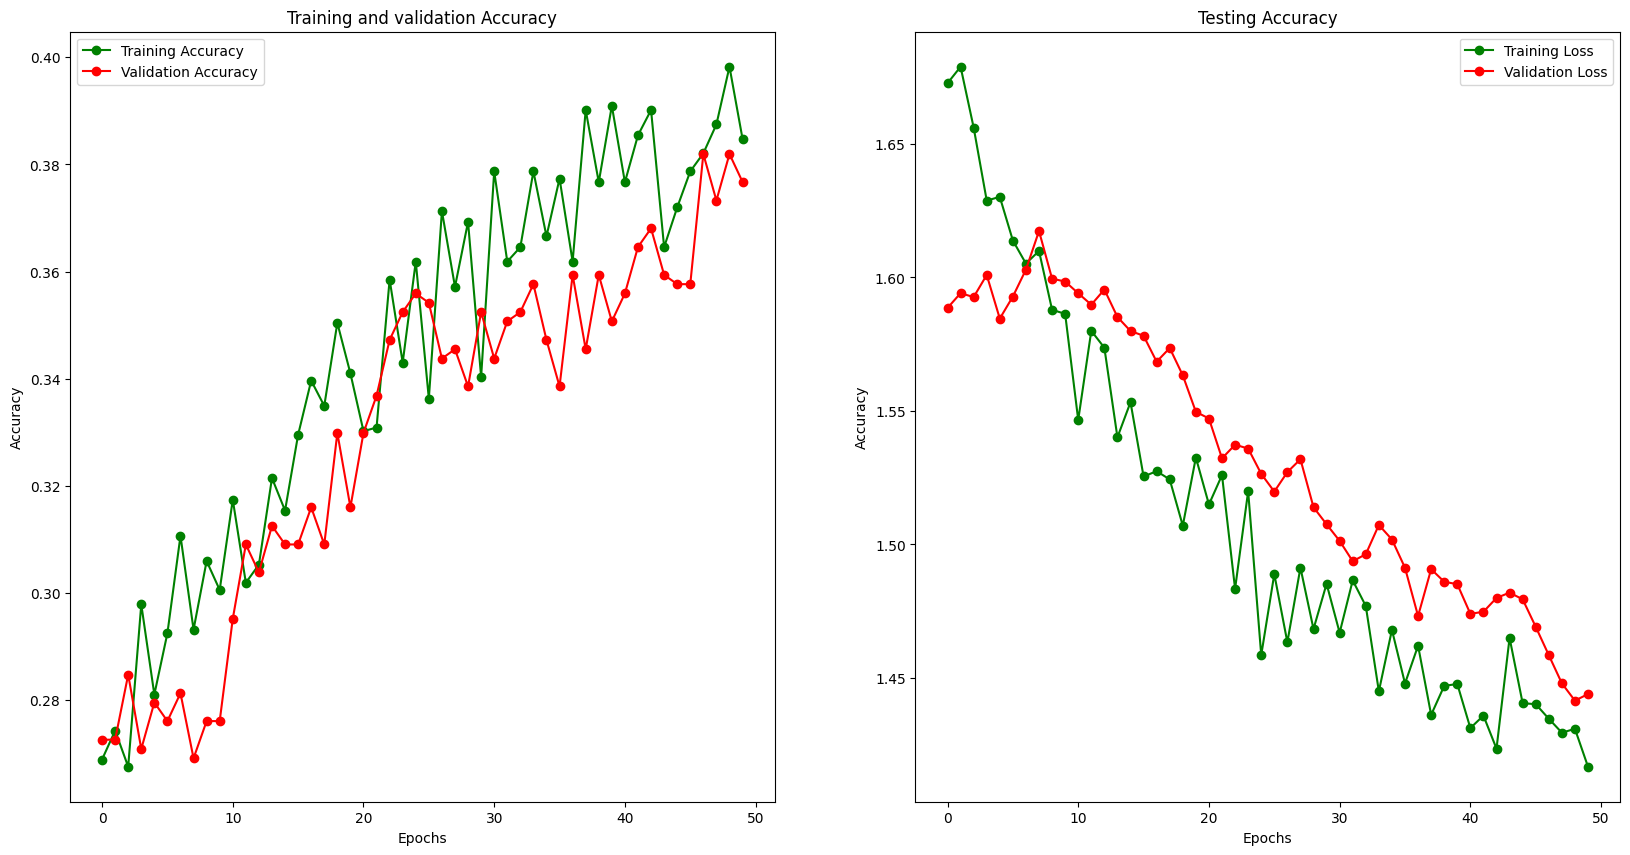

In [15]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

20/20 [==============================] - 3s 104ms/step


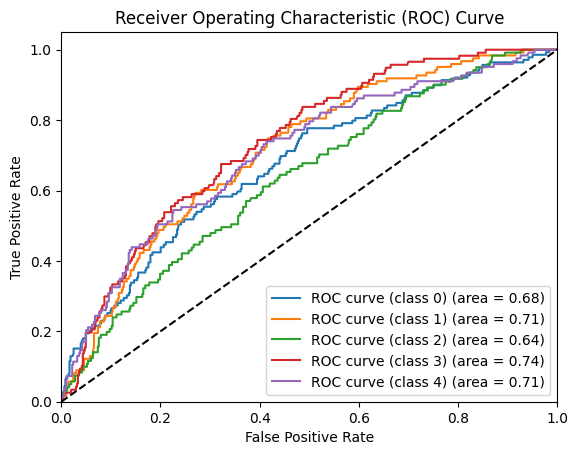

In [16]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 2

In [17]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True
    
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
47/47 [==============================] - 34s 721ms/step - loss: 1.6723 - accuracy: 0.2567 - val_loss: 1.5969 - val_accuracy: 0.2708
Epoch 2/50
47/47 [==============================] - 33s 699ms/step - loss: 1.6443 - accuracy: 0.2837 - val_loss: 1.6026 - val_accuracy: 0.2795
Epoch 3/50
47/47 [==============================] - 33s 701ms/step - loss: 1.6485 - accuracy: 0.2763 - val_loss: 1.6124 - val_accuracy: 0.2812
Epoch 4/50
47/47 [==============================] - 33s 701ms/step - loss: 1.6283 - accuracy: 0.2803 - val_loss: 1.6075 - val_accuracy: 0.2899
Epoch 5/50
47/47 [==============================] - 33s 710ms/step - loss: 1.6056 - accuracy: 0.2965 - val_loss: 1.6100 - val_accuracy: 0.2795
Epoch 6/50
47/47 [==============================] - 33s 702ms/step - loss: 1.6002 - accuracy: 0.2965 - val_loss: 1.6157 - val_accuracy: 0.2778
Epoch 7/50
47/47 [==============================] - 33s 704ms/step - loss: 1.5952 - accuracy: 0.3005 - val_loss: 1.6092 - val_accuracy: 0.2969

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

20/20 [==============================] - 2s 114ms/step - loss: 1.4742 - accuracy: 0.3740
Test accuracy: 0.37


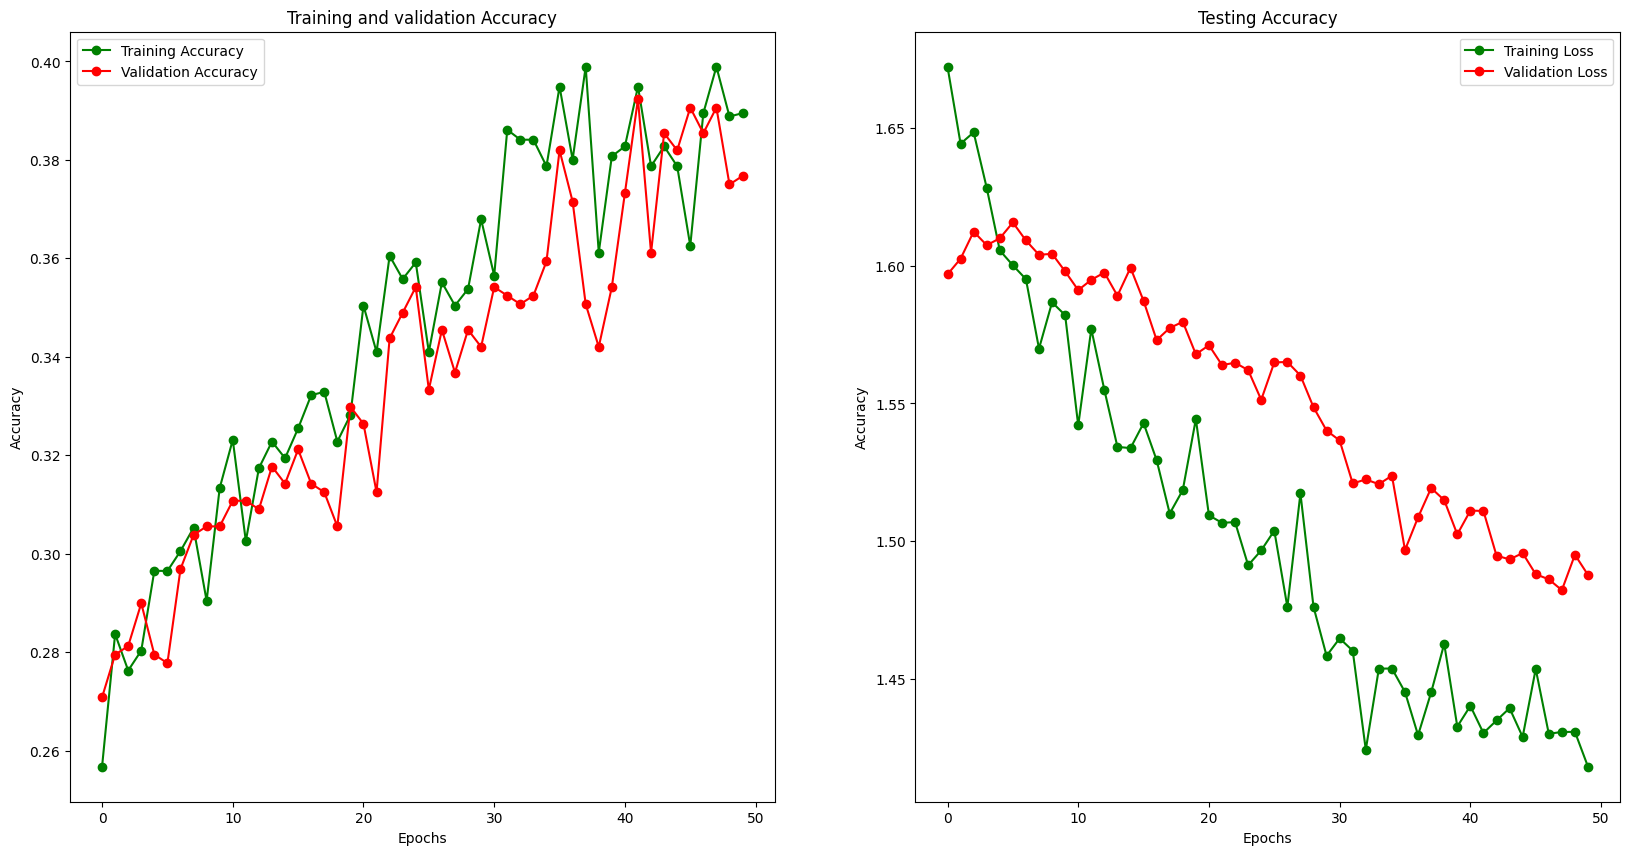

In [21]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

20/20 [==============================] - 3s 102ms/step


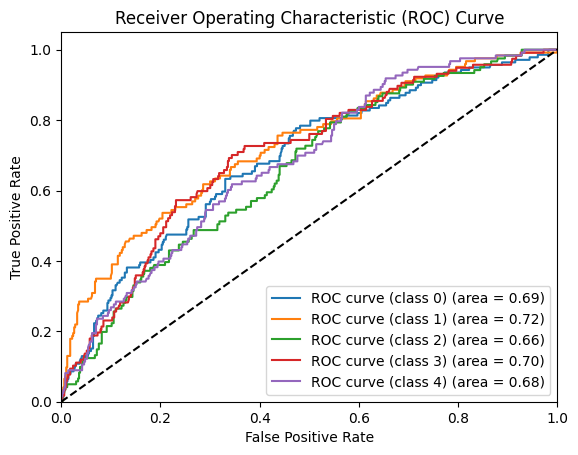

In [22]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

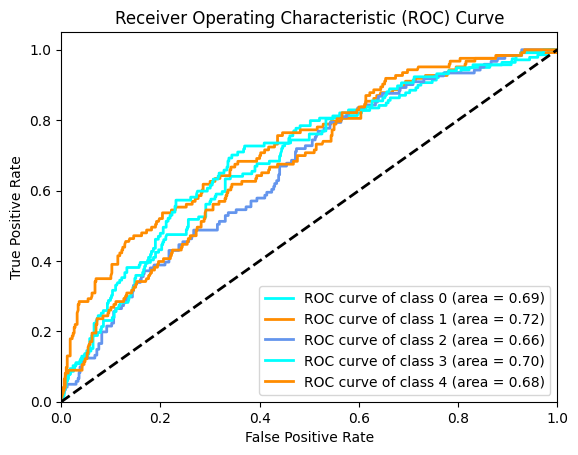

AUC for class 0: 0.69
AUC for class 1: 0.72
AUC for class 2: 0.66
AUC for class 3: 0.70
AUC for class 4: 0.68
Micro-average AUC: 0.69
Macro-average AUC: 0.69


In [25]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print out AUC values for each class
for i in range(num_classes):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')

# Print out micro and macro average AUC values
print(f'Micro-average AUC: {roc_auc["micro"]:.2f}')
print(f'Macro-average AUC: {roc_auc["macro"]:.2f}')